In [2]:
import itertools
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random
import Simulation
import time
import networkx as nx

from Algorithms.LAIM import *
from Algorithms.TIM  import *
from Algorithms.Proposed import *
from Algorithms.Heuristics import random_solution
from Diffusion.Model import *
from scipy.stats import arcsine
from tqdm import tqdm

sns.set_style("darkgrid")
RESULTS_PATH = os.path.join("..", "out", "results")
META_PATH = os.path.join(RESULTS_PATH, "meta.json")

## Experiment Design
Here we are interested in comparing the performance/efficacy of four baseline algorithms (i.e., `IRIE`, `TIM+`, `LAIM`, and `FastLAIM`) against our proposed solution (i.e., `OpinionDegree`) for opinion maximization under the BIC model.

More specifically, we are interested in this question under a few scenarios:
* Community-agnostic vs. Community-aware opinion initialization.
* Uniform opinion distribution vs. Polarized opinion distribution.

## Experimental Data Analysis
With all the data saved, now we need to visualize it for analysis. First, we need to load all of the saved `.csv` files that store the results from each simulation scenario. These will all be stored as one composite DataFrame in this notebook for simple visualizations in Seaborn.

The next block will load all of the data and visualize the head of it. Then successive blocks will be reserved for analysis.

In [3]:
import glob

amazon_data = pd.DataFrame()
for file in list(glob.glob(os.path.join(RESULTS_PATH, "topo=amazon*.csv"))):
    amazon_data = amazon_data.append(pd.read_csv(file))

dblp_data = pd.DataFrame()
for file in list(glob.glob(os.path.join(RESULTS_PATH, "topo=dblp*.csv"))):
    dblp_data = dblp_data.append(pd.read_csv(file))

dblp_data.head()

,Unnamed: 0,trial,opinion,activated,visited,algorithm,seed_size,algorithm_time,opinion_distr_func,ffm_distr_func,use_communities
0,0,0,158456.347325,44,550,degree_solution,1,0.650831,polarized,random,False
1,1,1,158442.574011,17,434,degree_solution,1,0.650831,polarized,random,False
2,2,2,158447.497231,27,411,degree_solution,1,0.650831,polarized,random,False
3,3,3,158439.861154,12,351,degree_solution,1,0.650831,polarized,random,False
4,4,4,158441.116388,14,400,degree_solution,1,0.650831,polarized,random,False


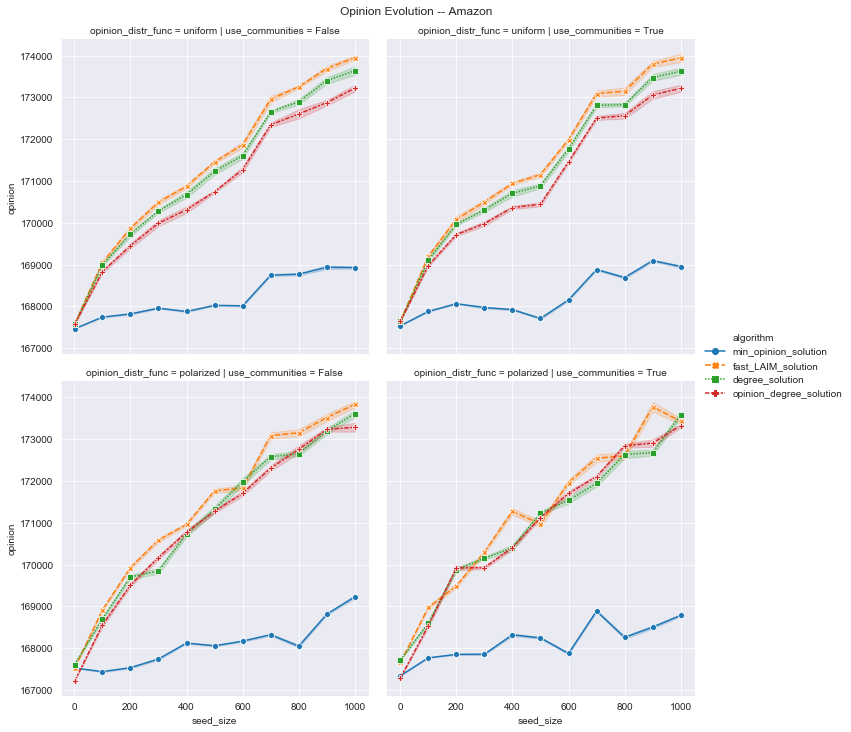

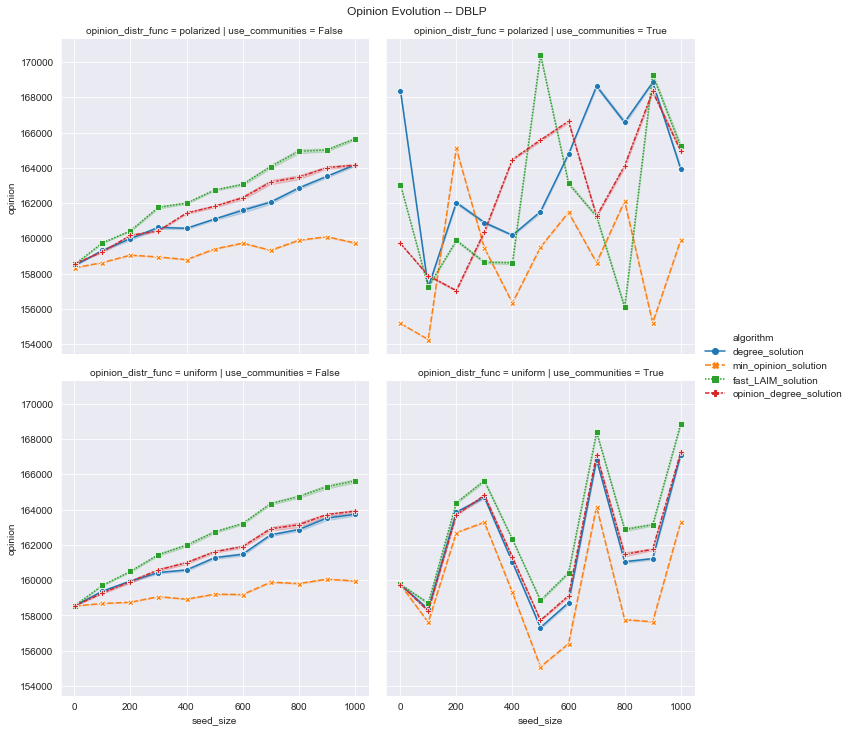

In [24]:
g = sns.relplot(
    x="seed_size", y="opinion", 
    col="use_communities", row="opinion_distr_func", 
    style="algorithm", kind="line", hue="algorithm",
    markers=True, ci="sd", #err_style="bars",
    data=amazon_data
)
plt.suptitle("Opinion Evolution -- Amazon", y=1.0125)
plt.show()

g = sns.relplot(
    x="seed_size", y="opinion", 
    col="use_communities", row="opinion_distr_func", 
    style="algorithm", kind="line", hue="algorithm",
    markers=True, ci="sd", #err_style="bars",
    data=dblp_data
)
plt.suptitle("Opinion Evolution -- DBLP", y=1.0125)
plt.show()

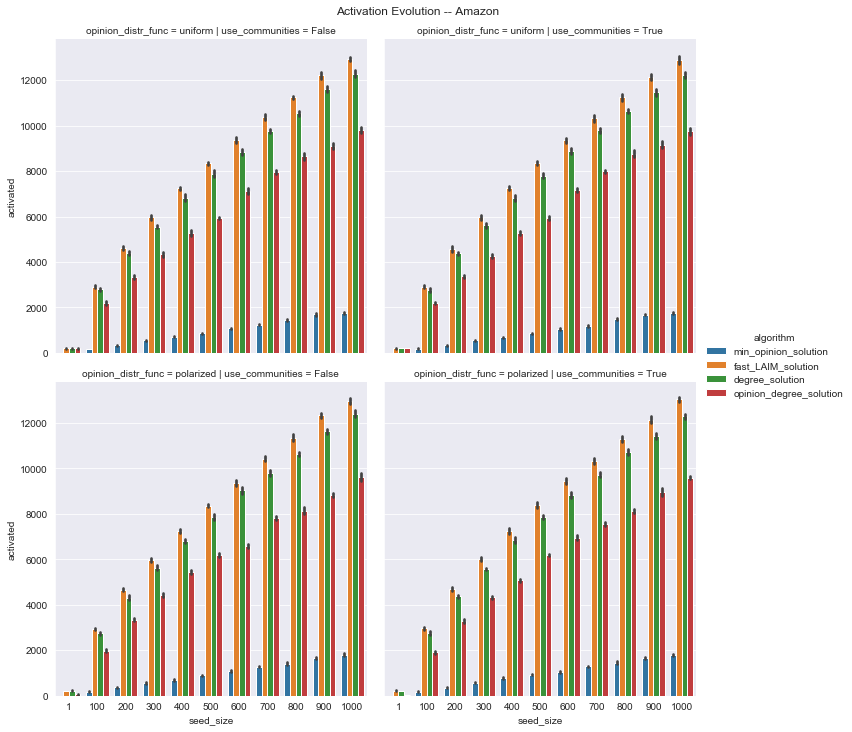

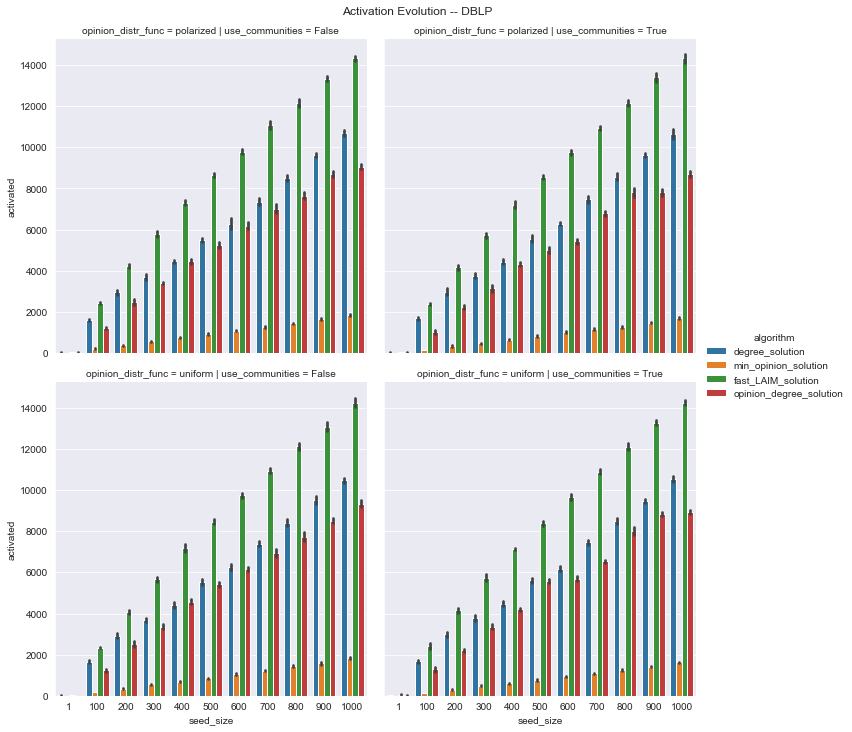

In [25]:
g = sns.catplot(
    x="seed_size", y="activated", 
    col="use_communities", row="opinion_distr_func", 
    # style="algorithm", 
    kind="bar", hue="algorithm",
    # markers=True, 
    ci="sd", #err_style="bars",
    data=amazon_data
)
plt.suptitle("Activation Evolution -- Amazon", y=1.0125)
plt.show()

g = sns.catplot(
    x="seed_size", y="activated", 
    col="use_communities", row="opinion_distr_func", 
    # style="algorithm", 
    kind="bar", hue="algorithm",
    # markers=True,
    ci="sd", #err_style="bars",
    data=dblp_data
)
plt.suptitle("Activation Evolution -- DBLP", y=1.0125)
plt.show()